## Desenvolvimento da 1a Etapa

In [59]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#imagem que vai ser usada como teste
imagem = sitk.ReadImage("images_filtered/IXI002-Guys-0828-T1.nii.gz")
img_np = sitk.GetArrayFromImage(imagem)

data_min = np.min(img_np)
data_max = np.max(img_np)
normalized_data = (img_np - data_min) / (data_max - data_min) * 255
normalized_data = normalized_data.astype(np.uint8)

atlas_csf = sitk.ReadImage("atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_csf.nii.gz")
atlas_gm = sitk.ReadImage("atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_gm.nii.gz")
atlas_wm = sitk.ReadImage("atlas_resampled/IXI002-Guys-0828-T1.nii.gz/mni_wm.nii.gz")

atlas_csf_array = sitk.GetArrayFromImage(atlas_csf)
atlas_gm_array = sitk.GetArrayFromImage(atlas_gm)
atlas_wm_array = sitk.GetArrayFromImage(atlas_wm)

binary_array_csf = (atlas_csf_array > 0.98).astype(np.uint8)
binary_array_gm = (atlas_gm_array > 0.98).astype(np.uint8)
binary_array_wm = (atlas_wm_array > 0.98).astype(np.uint8)

# Converter de volta para imagem SimpleITK
binary_image_csf = sitk.GetImageFromArray(binary_array_csf)
binary_image_csf.CopyInformation(atlas_csf)  # Mantém metadados da imagem original

binary_image_gm = sitk.GetImageFromArray(binary_array_gm)
binary_image_gm.CopyInformation(atlas_gm)  # Mantém metadados da imagem original

binary_image_wm = sitk.GetImageFromArray(binary_array_wm)
binary_image_wm.CopyInformation(atlas_wm)  # Mantém metadados da imagem original

mask_np_csf = (binary_array_csf > 0).astype(np.uint8)
mask_np_gm = (binary_array_gm > 0).astype(np.uint8)
mask_np_wm = (binary_array_wm > 0).astype(np.uint8)

result_np_csf = (normalized_data * mask_np_csf)
result_np_gm = (normalized_data * mask_np_gm)
result_np_wm = (normalized_data * mask_np_wm)

vetor_np_csf = result_np_csf[result_np_csf>0]
vetor_np_csf_mean = np.mean(vetor_np_csf)
print(f"Vetor final média csf: {vetor_np_csf_mean}.")

vetor_np_gm = result_np_gm[result_np_gm>0]
vetor_np_gm_mean = np.mean(vetor_np_gm)
print(f"Vetor final média gm: {vetor_np_gm_mean}.")


vetor_np_wm = result_np_wm[result_np_wm>0]
vetor_np_wm_mean = np.mean(vetor_np_wm)
print(f"Vetor final média wm: {vetor_np_wm_mean}.")


### Usar o kmeans com as três médias advindas das imagens. Fazer a clusterização da imagem original mediante as três médias.

Convergência atingida após 8 iterações.


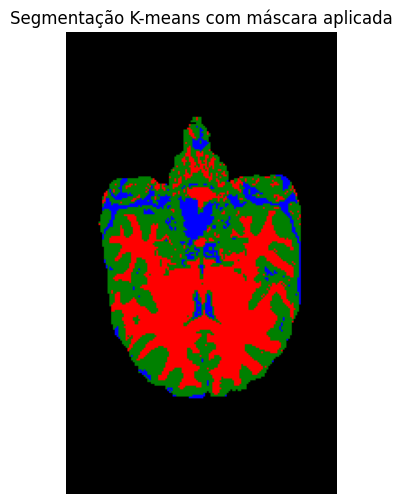


Volumes calculados:
Classe 0 (Vermelho): 712198.00 mm³
Classe 1 (Azul): 8346355.00 mm³
Classe 2 (Verde): 771847.00 mm³


In [ ]:
# --- Carregar a imagem original ---
image_path = "image_norm.nii.gz"  # Modifique para o caminho da sua imagem
nifti_image = nib.load(image_path)
image_data = nifti_image.get_fdata()  # Array NumPy da imagem

# --- Carregar a máscara ---
mask_path = "atlas_resampled\IXI002-Guys-0828-T1.nii.gz\mni_mask.nii.gz"  # Caminho do arquivo enviado
mask_nifti = nib.load(mask_path)
mask_data = mask_nifti.get_fdata()  # Array NumPy da máscara

# --- Aplicar a máscara (mantendo apenas a parte branca) ---
image_data[mask_data == 0] = 0

# Obter o tamanho do voxel em mm (dimensão do voxel)
voxel_size = np.prod(nifti_image.header.get_zooms())  # Multiplica (dx, dy, dz) para obter mm³

# Definir as médias fornecidas para os 3 clusters
cluster_means = np.array([[vetor_np_csf_mean], [vetor_np_gm_mean], [vetor_np_wm_mean]])  # Exemplo de valores médios

# Número de clusters
k = len(cluster_means)

# Inicializar centroides com as médias fornecidas
centroids = cluster_means.copy()

# Função para atribuir cada pixel ao cluster mais próximo
def assign_to_cluster(image_data, centroids):
    distances = np.abs(image_data[..., None] - centroids.flatten())
    return np.argmin(distances, axis=-1)

# Função para atualizar os centroids
def update_centroids(image_data, labels, k):
    new_centroids = np.zeros(k)
    for i in range(k):
        if np.any(labels == i):
            new_centroids[i] = np.mean(image_data[labels == i])
        else:
            new_centroids[i] = centroids[i]  # Mantém se não houver atualização
    return new_centroids

# Número máximo de iterações
max_iters = 100
tolerance = 1e-4
prev_centroids = np.zeros_like(centroids)

# Iteração do K-means
for iteration in range(max_iters):
    labels = assign_to_cluster(image_data, centroids)
    centroids = update_centroids(image_data, labels, k)
    
    if np.all(np.abs(centroids - prev_centroids) < tolerance):
        print(f"Convergência atingida após {iteration + 1} iterações.")
        break
    
    prev_centroids = centroids.copy()

# Criar uma imagem RGB para visualização
segmented_rgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

# Definir as cores (R, G, B)
colors = {
    0: [255, 0, 0],      # Vermelho (Primeira classe)
    1: [0, 0, 255],      # Azul (Segunda classe)
    2: [0, 128, 0],  # Verde (Terceira classe)
}

# Atribuir cores aos pixels classificados
for class_id, color in colors.items():
    segmented_rgb[labels == class_id] = color

# Aplicar a máscara na segmentação (fundo preto)
segmented_rgb[mask_data == 0] = [0, 0, 0]

# Mostrar um corte da segmentação
slice_index = segmented_rgb.shape[0] // 2  # Pegar um corte no meio
plt.figure(figsize=(8, 6))
plt.imshow(segmented_rgb[slice_index])  # Mostrar a imagem colorida
plt.title("Segmentação K-means com máscara aplicada")
plt.axis("off")
plt.show()

# --- Cálculo do Volume ---
volumes = {}
for class_id in range(k):
    num_voxels = np.sum(labels == class_id)  # Contar número de voxels na classe
    volume_mm3 = num_voxels * voxel_size  # Multiplicar pelo tamanho do voxel
    volumes[class_id] = volume_mm3

# Exibir resultados
print("\nVolumes calculados:")
for class_id, volume in volumes.items():
    print(f"Classe {class_id} ({['Vermelho', 'Azul', 'Verde'][class_id]}): {volume:.2f} mm³")
